In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import pickle
import sys
sys.path.append('..')

In [2]:
notebook_name = os.path.basename(os.getcwd())
timestamp="07"

In [3]:
path_movie_dir = '../data/movie/'
path_save_dir = os.path.join('../data/06_Evaluation_new/', timestamp)
if not os.path.exists(path_save_dir):
    os.makedirs(path_save_dir)
#path_save_file = os.path.join(path_save_dir, 'test_data.csv')
path_save_file = os.path.join(path_save_dir, 'test.csv')

In [4]:
path_label_name_file = '../data/labels/labels_num.csv'
path_action_dir = os.path.join('../data/01_DataProcessing/', timestamp)
path_point_dir = os.path.join('../data/02_GetPoints/', timestamp)
path_split_dir = os.path.join('../data/04_Split_new/', timestamp)
path_test_file_dir = os.path.join(path_split_dir, 'test')
path_test_file = os.path.join(path_test_file_dir, 'test.csv')
path_model_dir = os.path.join('../data/05_train_new/', timestamp)
path_model_file = os.path.join(path_model_dir, 'model.pkl')

In [5]:
file_names = ['test']
# file_names = ['forehand']
movie_names = [file_name + '.MOV' for file_name in file_names]
points_file_names = [file_name + '.csv' for file_name in file_names]

In [6]:
path_split_dir = os.path.join('../data/04_Split_new/', timestamp)
path_test_file_dir = os.path.join(path_split_dir, 'test')

In [7]:
objective = 'action_gt_num'

In [8]:
label_names = pd.read_csv(path_label_name_file)

In [9]:
label_names

,action_gt_name,action_gt_num
0,stand,0
1,fall,1
2,sittingdown,2
3,standingup,3
4,sitdown,4


In [10]:

gbm = pickle.load(open(path_model_file, "rb"))
path_model_file

'../data/05_train_new/07\\model.pkl'

In [11]:
feature_name_list = gbm.feature_name()

In [12]:
target_columns = ['RShoulder_x','RShoulder_y','RHip_x','RHip_y','RKnee_x','RKnee_y',
                  'Neck_x','Neck_y','Nose_x','Nose_y','LShoulde_x','LShoulde_y',
                  'LHip_x','LHip_y','LKnee_x','LKnee_y']

In [13]:
frame_length = 15
assert frame_length == int(len(feature_name_list) / len(target_columns))
frame_length

15

In [14]:
new_data_df = None
for num, points_file_name in enumerate(points_file_names):
    print(points_file_name)
    path_file = os.path.join(path_test_file_dir, points_file_name)
    data_df = pd.read_csv(path_file, index_col='frame_num')
    units_df = None
    for idx in data_df.index[frame_length:len(data_df)]:
        unit_df = data_df.loc[idx - frame_length: idx-1]
        y = unit_df[objective]
        Y=y.loc[idx-1]
        X = unit_df.drop(columns=[objective]).loc[:, target_columns]
        flatten_data=X.to_numpy().reshape(1,-1)
        A=['RShoulder_x','RShoulder_y', 'RHip_x', 'RHip_y','RKnee_x',
 'RKnee_y', 'Neck_x', 'Neck_y', 'Nose_x', 'Nose_y', 'LShoulde_x', 'LShoulde_y',
 'LHip_x', 'LHip_y', 'LKnee_x', 'LKnee_y']
        B=[a+"_"+str(i-14) for i in range(15) for a in A]
        X=pd.DataFrame(flatten_data,columns=B)
        X["action_gt_num"]=Y
        unit_df = X
        if units_df is None:
            units_df = unit_df
        else:
            units_df = pd.concat([units_df, unit_df], axis=0, sort=False)
    path_save_file = os.path.join(path_save_dir, points_file_name)
    units_df.to_csv(path_save_file)
    if new_data_df is None:
        new_data_df = units_df
    else:
        new_data_df = pd.concat([new_data_df, units_df], axis=0, sort=False)
test_data_df = new_data_df.copy()
test_data_df.to_csv(path_test_file)

test.csv


In [15]:
test_data_df.groupby(objective).count()

,RShoulder_x_-14,RShoulder_y_-14,RHip_x_-14,RHip_y_-14,RKnee_x_-14,RKnee_y_-14,Neck_x_-14,Neck_y_-14,Nose_x_-14,Nose_y_-14,...,Neck_x_0,Neck_y_0,Nose_x_0,Nose_y_0,LShoulde_x_0,LShoulde_y_0,LHip_x_0,LHip_y_0,LKnee_x_0,LKnee_y_0
action_gt_num,,,,,,,,,,,,,,,,,,,,,
0,337,337,337,337,337,337,337,337,337,337,...,337,337,337,337,337,337,337,337,337,337
1,228,228,228,228,228,228,228,228,228,228,...,228,228,228,228,228,228,228,228,228,228
2,74,74,74,74,74,74,74,74,74,74,...,74,74,74,74,74,74,74,74,74,74
3,117,117,117,117,117,117,117,117,117,117,...,117,117,117,117,117,117,117,117,117,117
4,210,210,210,210,210,210,210,210,210,210,...,210,210,210,210,210,210,210,210,210,210


In [16]:
test_data_df['dummy'] = 1
test_data_df.groupby(objective).count()['dummy']

action_gt_num
0    337
1    228
2     74
3    117
4    210
Name: dummy, dtype: int64

In [17]:
X_test_data_df = test_data_df.drop([objective], axis=1)
y_test_data_df = test_data_df[objective]

In [18]:
y_pred = gbm.predict(X_test_data_df, num_iteration=gbm.best_iteration)
y_pred = np.argmax(y_pred, axis=1)

In [19]:
objective_pred = 'action_pred_num'

In [20]:
test_data_df[objective_pred] = y_pred
test_data_df = test_data_df.reset_index(drop=True)

In [21]:
accuracy_all = np.sum(test_data_df[objective] == test_data_df[objective_pred]) / len(test_data_df)


In [22]:
print('accuracy: ', round(accuracy_all*100, 2), ' %')


accuracy:  57.14  %


In [23]:
objective_rev_dict = label_names.to_dict()['action_gt_name']


In [24]:
test_data_df['action_gt_name'] = test_data_df[objective].apply(lambda x: objective_rev_dict[x])
test_data_df['action_pred_name'] = test_data_df[objective_pred].apply(lambda x: objective_rev_dict[x])


In [25]:
test_data_df.columns


Index(['RShoulder_x_-14', 'RShoulder_y_-14', 'RHip_x_-14', 'RHip_y_-14',
       'RKnee_x_-14', 'RKnee_y_-14', 'Neck_x_-14', 'Neck_y_-14', 'Nose_x_-14',
       'Nose_y_-14',
       ...
       'LShoulde_y_0', 'LHip_x_0', 'LHip_y_0', 'LKnee_x_0', 'LKnee_y_0',
       'action_gt_num', 'dummy', 'action_pred_num', 'action_gt_name',
       'action_pred_name'],
      dtype='object', length=245)

In [26]:
from sklearn.metrics import confusion_matrix

In [27]:
objective_names = list(objective_rev_dict.values())
objective_names

['stand', 'fall', 'sittingdown', 'standingup', 'sitdown']

In [28]:
confusion_matrix_df = confusion_matrix(test_data_df[objective], test_data_df[objective_pred])


In [29]:
objective_names_pred = [objective_name + '_pred' for objective_name in objective_names]
objective_names_gt = [objective_name + '_gt' for objective_name in objective_names]

In [30]:
confusion_matrix_df

array([[312,  11,   2,   5,   7],
       [  7, 212,   0,   8,   1],
       [ 48,   1,  21,   0,   4],
       [ 69,  27,  21,   0,   0],
       [ 78, 121,   4,   0,   7]], dtype=int64)

In [31]:
confusion_matrix_df = pd.DataFrame(confusion_matrix_df, columns=objective_names_pred, index=objective_names_gt)
confusion_matrix_df

,stand_pred,fall_pred,sittingdown_pred,standingup_pred,sitdown_pred
stand_gt,312,11,2,5,7
fall_gt,7,212,0,8,1
sittingdown_gt,48,1,21,0,4
standingup_gt,69,27,21,0,0
sitdown_gt,78,121,4,0,7


In [32]:
# Precision
confusion_matrix_df / confusion_matrix_df.sum(axis=0) * 100

,stand_pred,fall_pred,sittingdown_pred,standingup_pred,sitdown_pred
stand_gt,60.700389,2.956989,4.166667,38.461538,36.842105
fall_gt,1.361868,56.989247,0.000000,61.538462,5.263158
sittingdown_gt,9.338521,0.268817,43.750000,0.000000,21.052632
standingup_gt,13.424125,7.258065,43.750000,0.000000,0.000000
sitdown_gt,15.175097,32.526882,8.333333,0.000000,36.842105


In [33]:
# Recall
(confusion_matrix_df.T / confusion_matrix_df.sum(axis=1)).T * 100

,stand_pred,fall_pred,sittingdown_pred,standingup_pred,sitdown_pred
stand_gt,92.581602,3.264095,0.593472,1.483680,2.077151
fall_gt,3.070175,92.982456,0.000000,3.508772,0.438596
sittingdown_gt,64.864865,1.351351,28.378378,0.000000,5.405405
standingup_gt,58.974359,23.076923,17.948718,0.000000,0.000000
sitdown_gt,37.142857,57.619048,1.904762,0.000000,3.333333


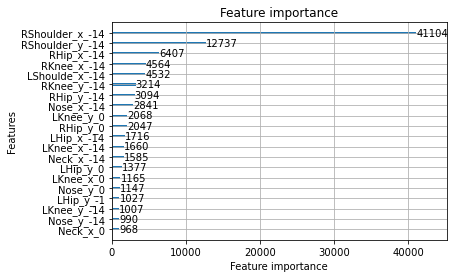

In [34]:
lgb.plot_importance(gbm, max_num_features=20)
